In [15]:

import pandas as pd
import sys

sys.path.insert(1, '../rule_lib')

from rule_benchmark import *

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
FOLDERS = ["approach1", "approach2"]

In [18]:
train_total = pd.read_pickle("train.pkl")
test_total = pd.read_pickle("test.pkl")

TOP_K_SAMPLES = 1

train = train_total[train_total["ranking"] < TOP_K_SAMPLES]
test = test_total[test_total["ranking"] < TOP_K_SAMPLES]

Number of rules:  35
Number of input variables:  4
Number of output variables:  4

approach1/:

Container:
	Test set:
		VerletClusterLists      :  71.43%	(5/7)
		VerletListsCells        :  66.67%	(4/6)
		LinkedCells             :   0.00%	(0/1)
		Total                   :  64.29%	(9/14)

	Train set:
		VerletListsCells        :  96.30%	(26/27)
		VerletClusterLists      :  84.00%	(21/25)
		LinkedCells             :   0.00%	(0/4)
		Total                   :  83.93%	(47/56)

Traversal:
	Test set:
		vcl_c06                 :  66.67%	(2/3)
		vlc_c01                 :   0.00%	(0/1)
		vlc_c18                 :  50.00%	(2/4)
		vcl_cluster_iteration   :  25.00%	(1/4)
		lc_c01                  :   0.00%	(0/1)
		vlc_sliced_c02          :   0.00%	(0/1)
		Total                   :  35.71%	(5/14)

	Train set:
		vlc_c18                 :  95.24%	(20/21)
		vcl_c06                 : 100.00%	(11/11)
		vlc_sliced_c02          :  25.00%	(1/4)
		lc_sliced_balanced      :   0.00%	(0/1)
		vlc_c01              

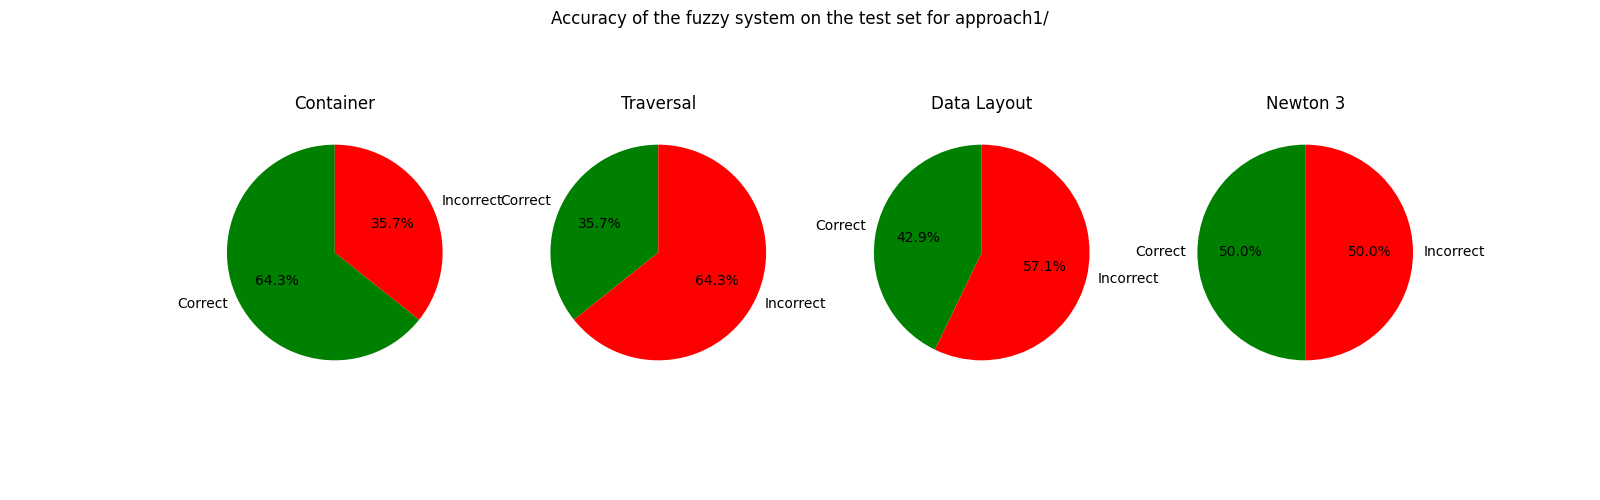

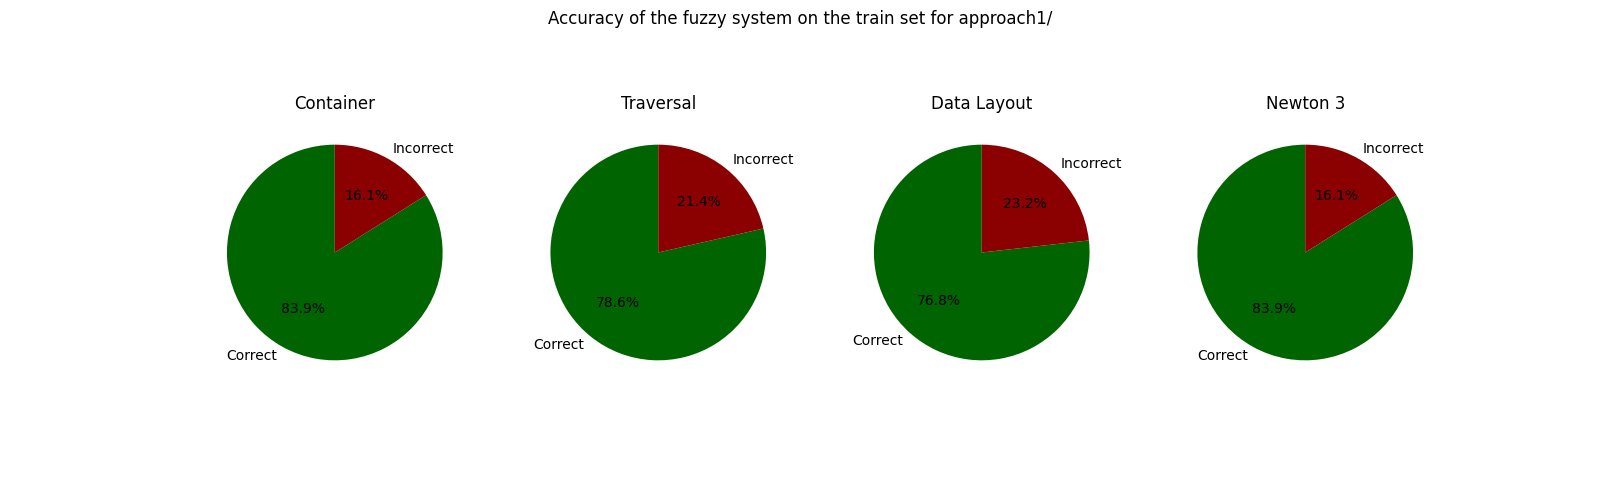

Number of rules:  35
Number of input variables:  4
Number of output variables:  4

approach2/:

Container:
	Test set:
		VerletClusterLists      :  71.43%	(5/7)
		VerletListsCells        :  66.67%	(4/6)
		LinkedCells             :   0.00%	(0/1)
		Total                   :  64.29%	(9/14)

	Train set:
		VerletListsCells        : 100.00%	(27/27)
		VerletClusterLists      :  80.00%	(20/25)
		LinkedCells             :   0.00%	(0/4)
		Total                   :  83.93%	(47/56)

Traversal:
	Test set:
		vcl_c06                 :  66.67%	(2/3)
		vlc_c01                 :   0.00%	(0/1)
		vlc_c18                 :  50.00%	(2/4)
		vcl_cluster_iteration   :  25.00%	(1/4)
		lc_c01                  :   0.00%	(0/1)
		vlc_sliced_c02          : 100.00%	(1/1)
		Total                   :  42.86%	(6/14)

	Train set:
		vlc_c18                 :  95.24%	(20/21)
		vcl_c06                 : 100.00%	(11/11)
		vlc_sliced_c02          :  75.00%	(3/4)
		lc_sliced_balanced      :   0.00%	(0/1)
		vlc_c01              

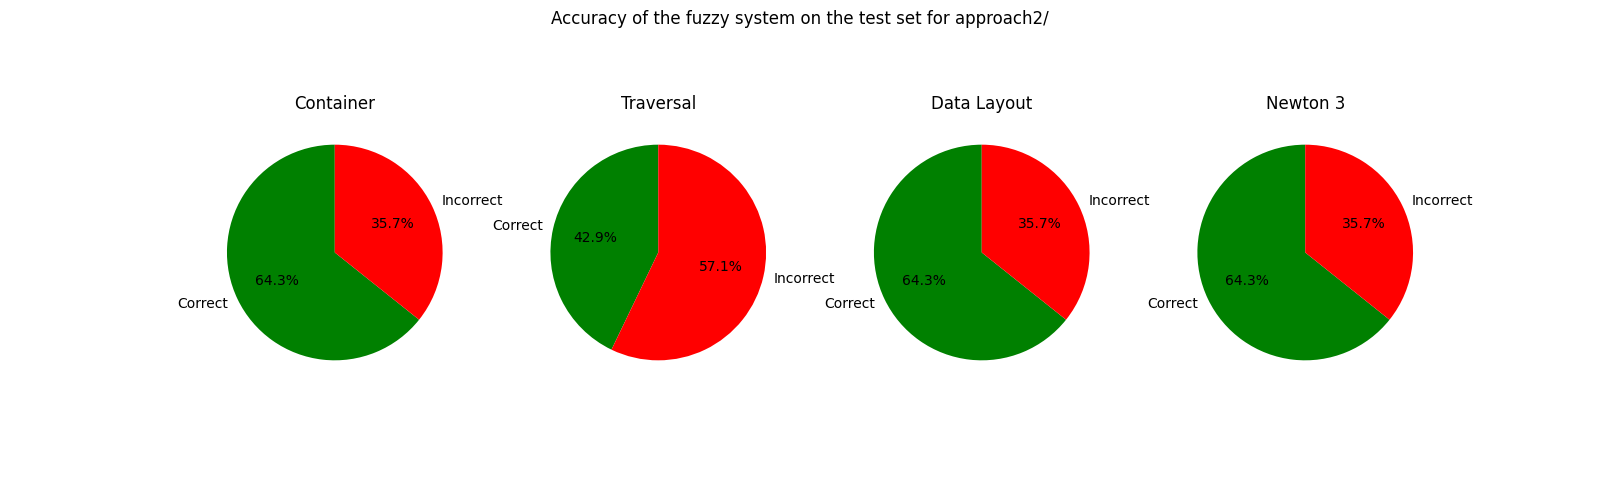

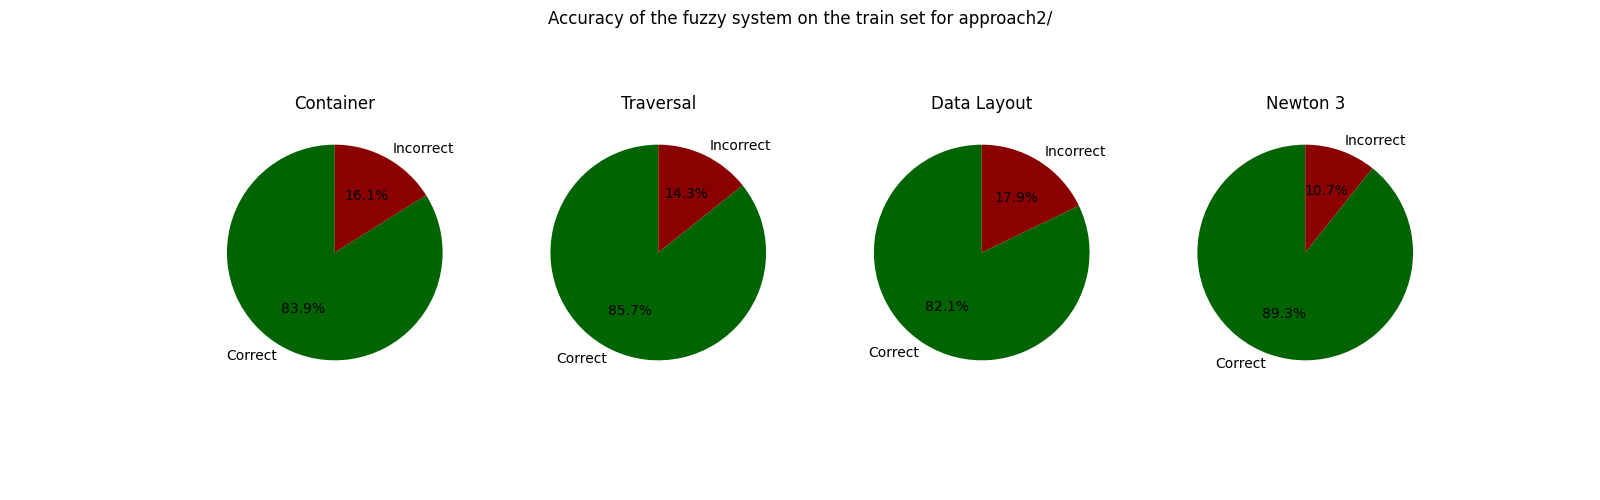

In [19]:
benchmark_rules("approach1/", train, test)
fiss, algo_ranking = benchmark_rules("approach2/", train, test)

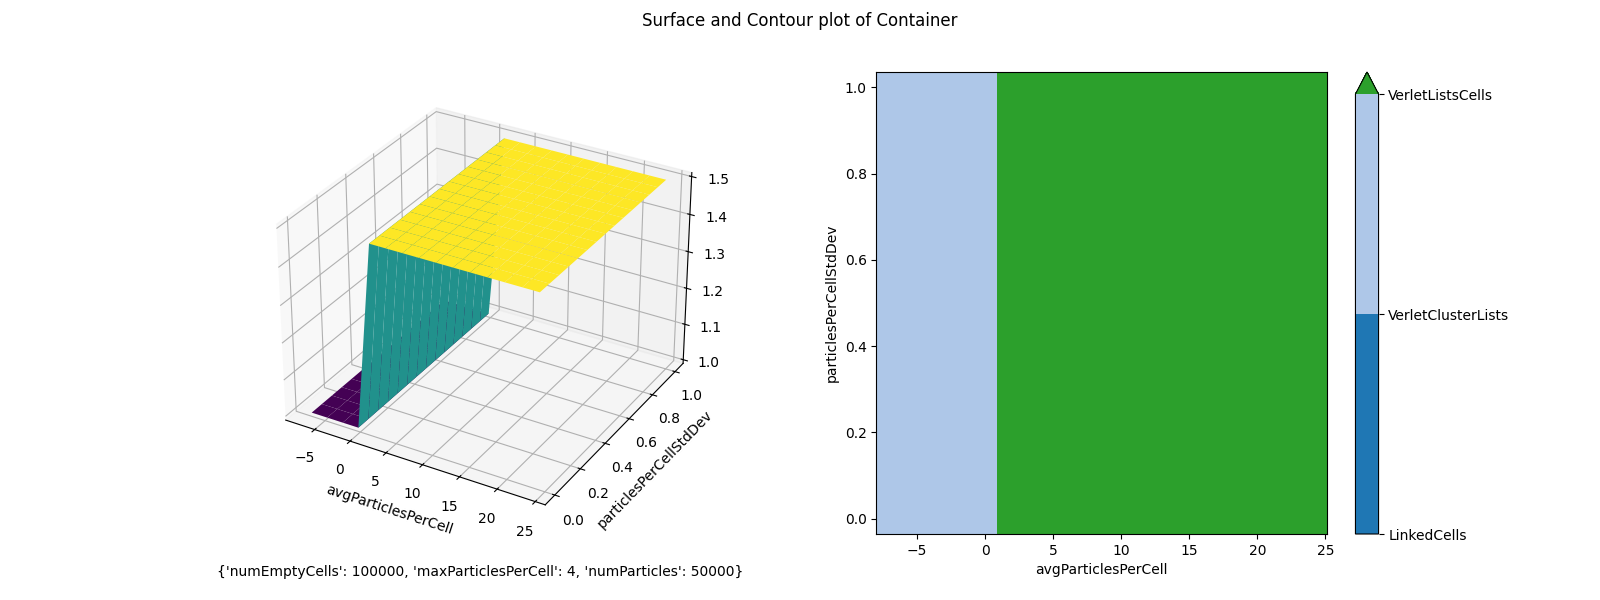

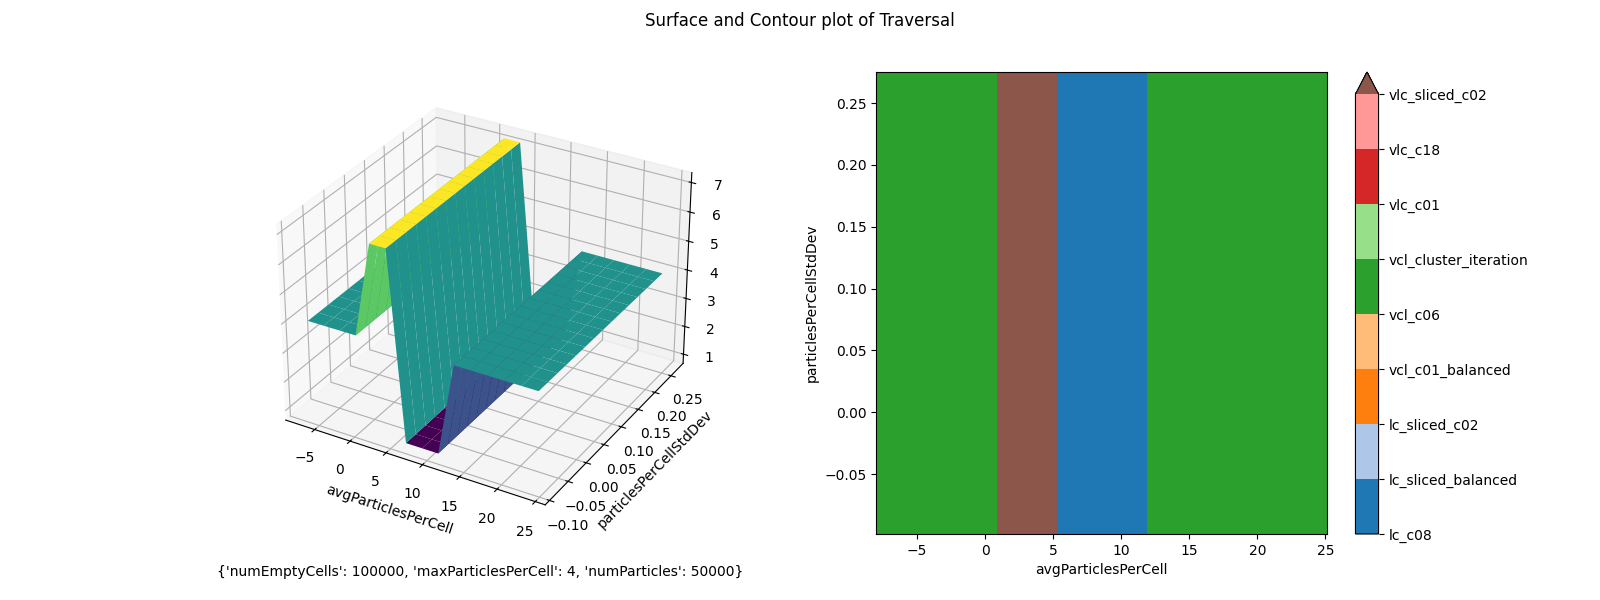

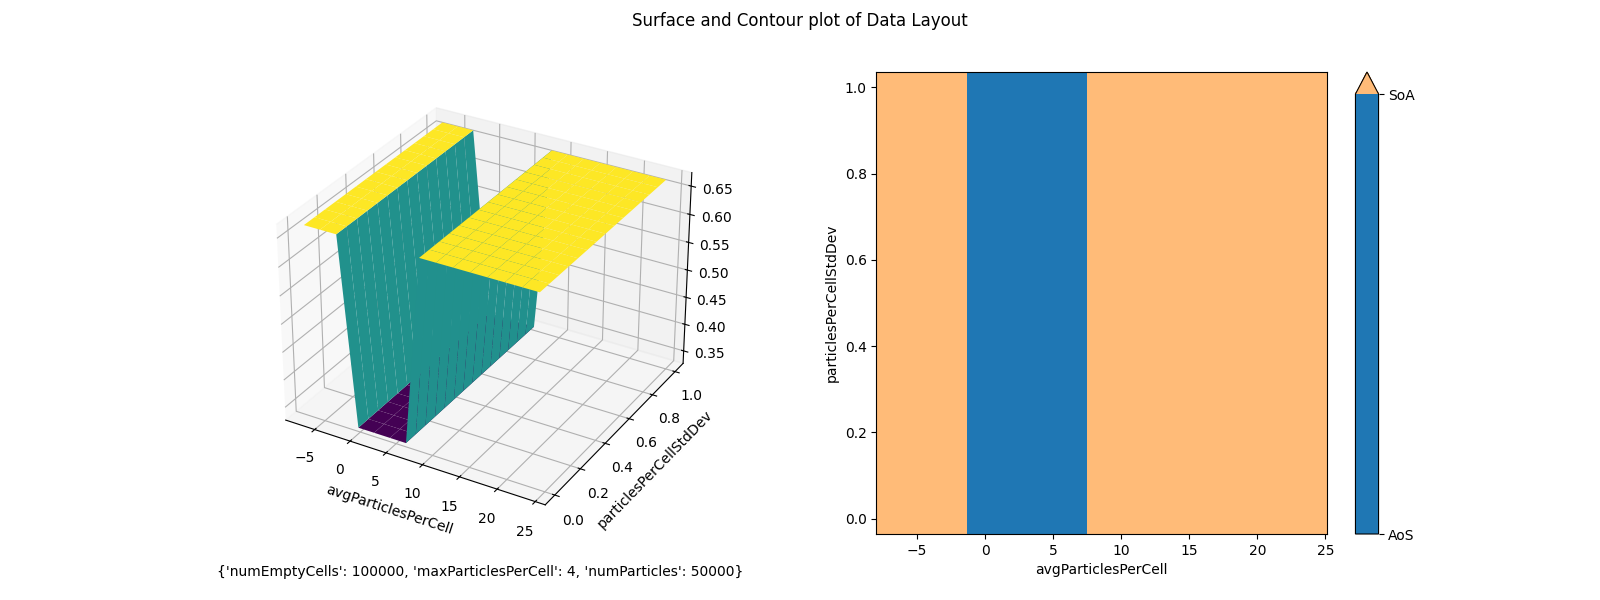

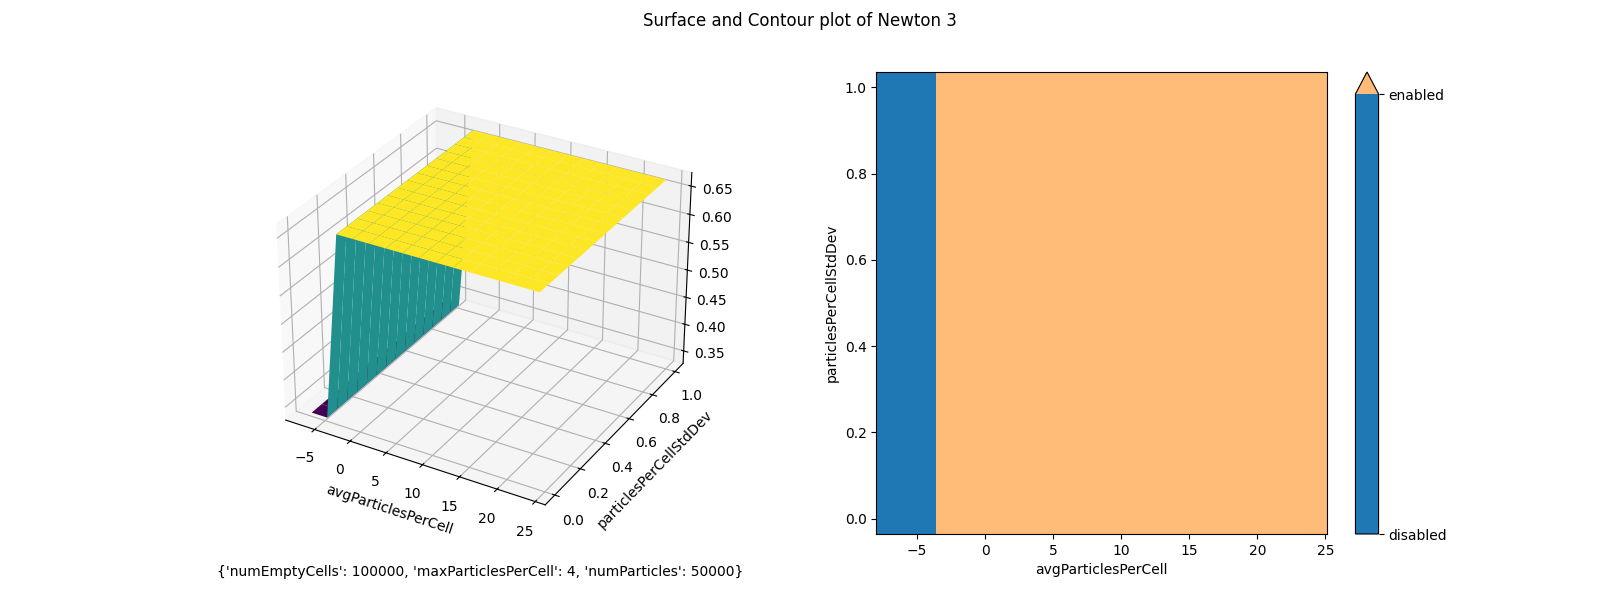

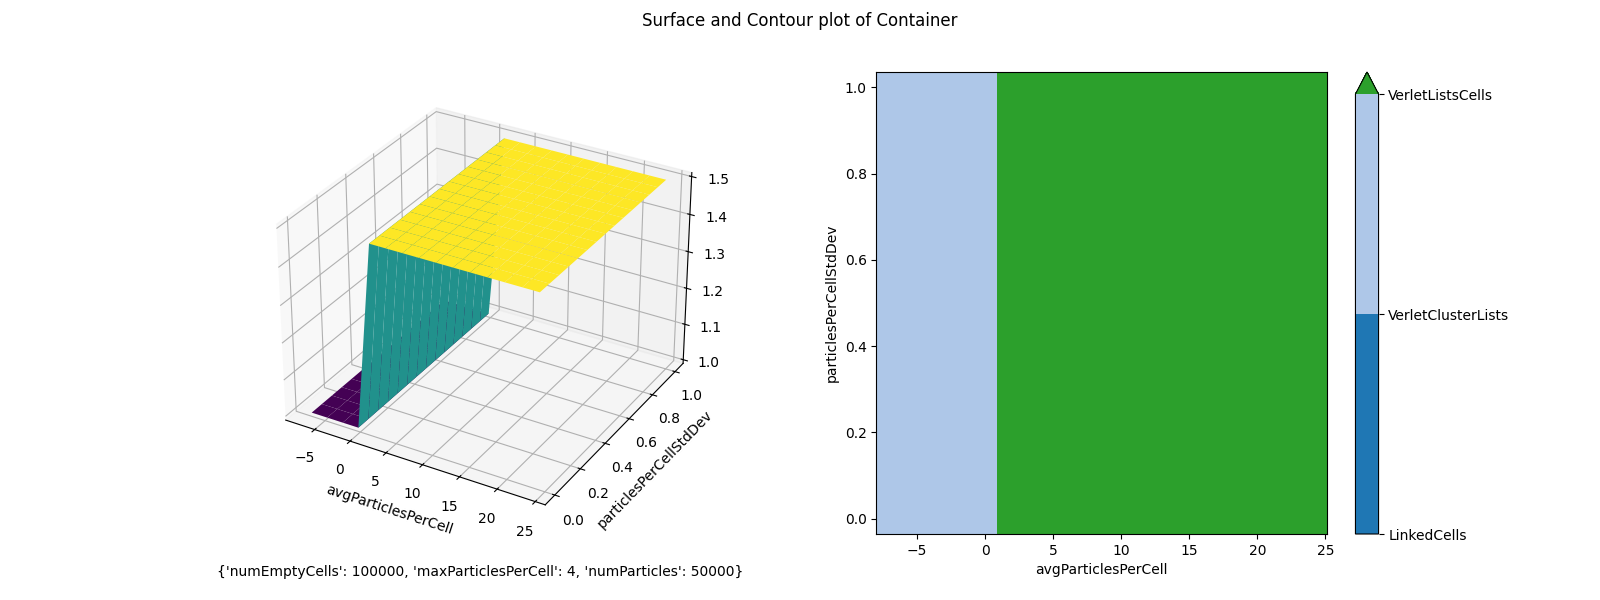

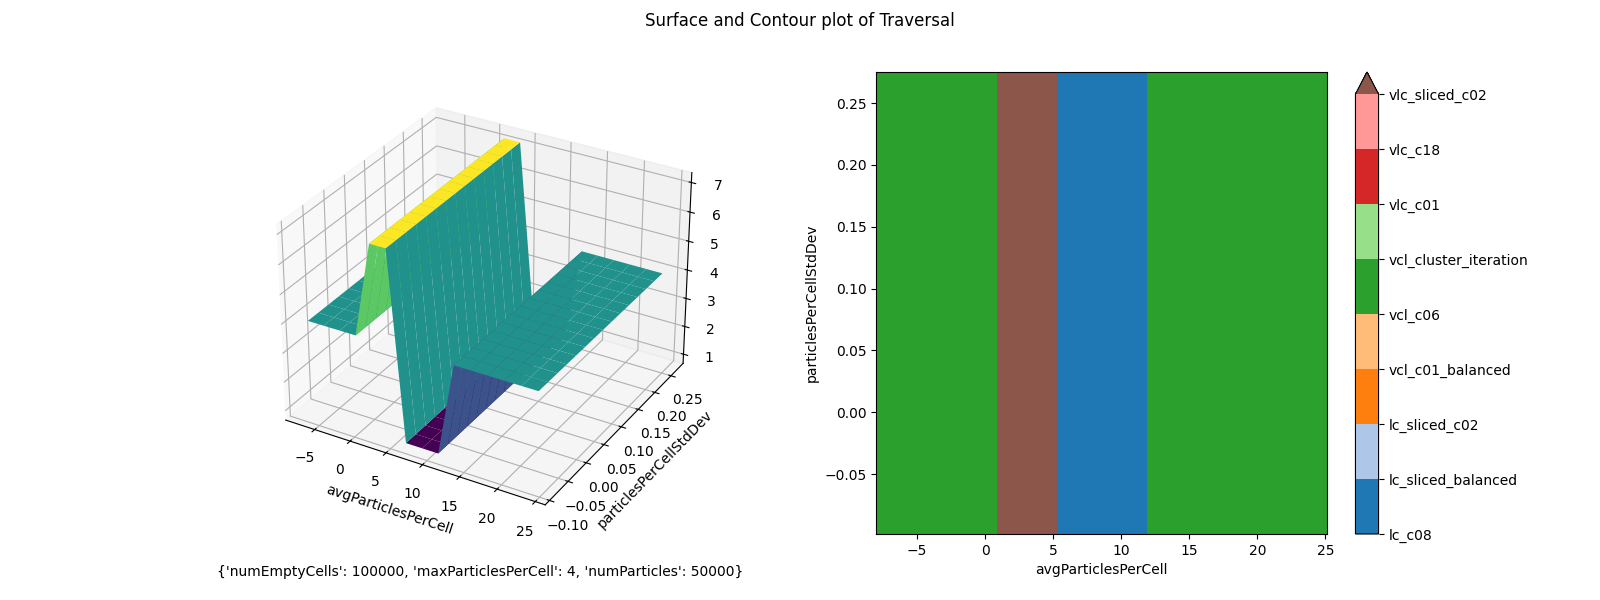

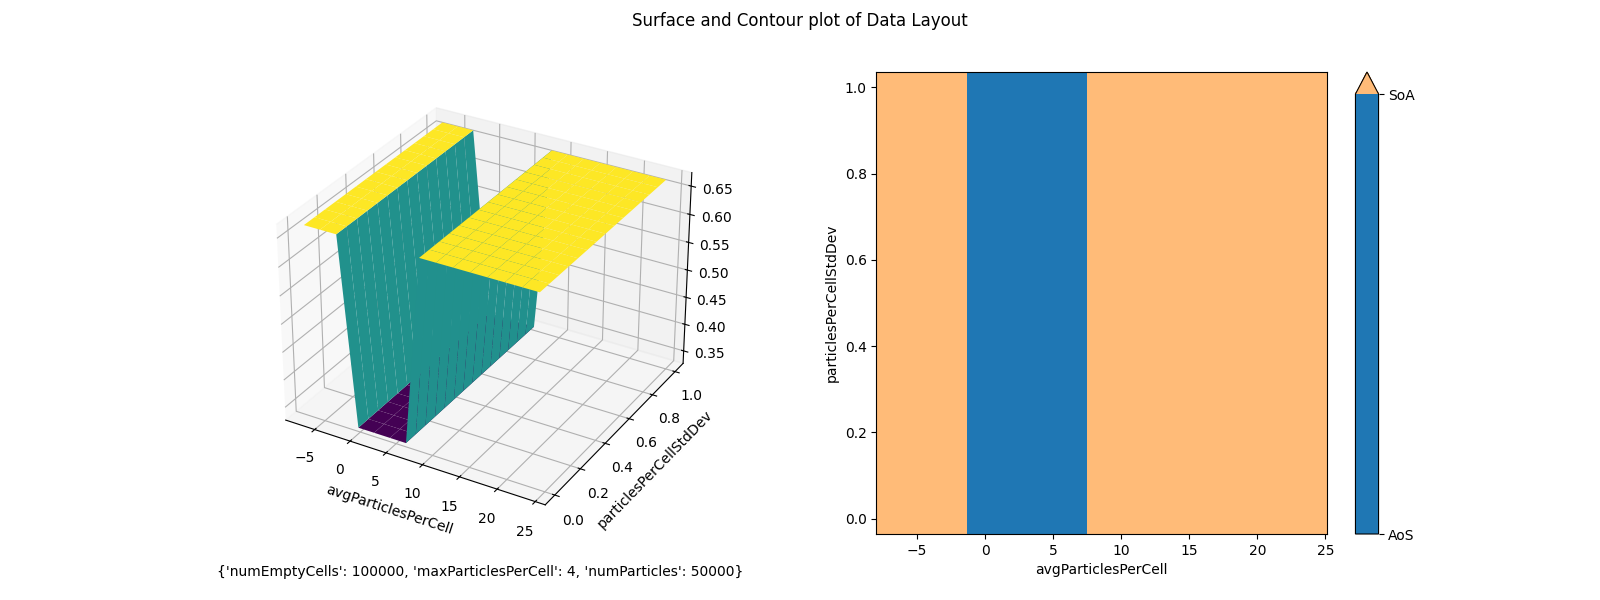

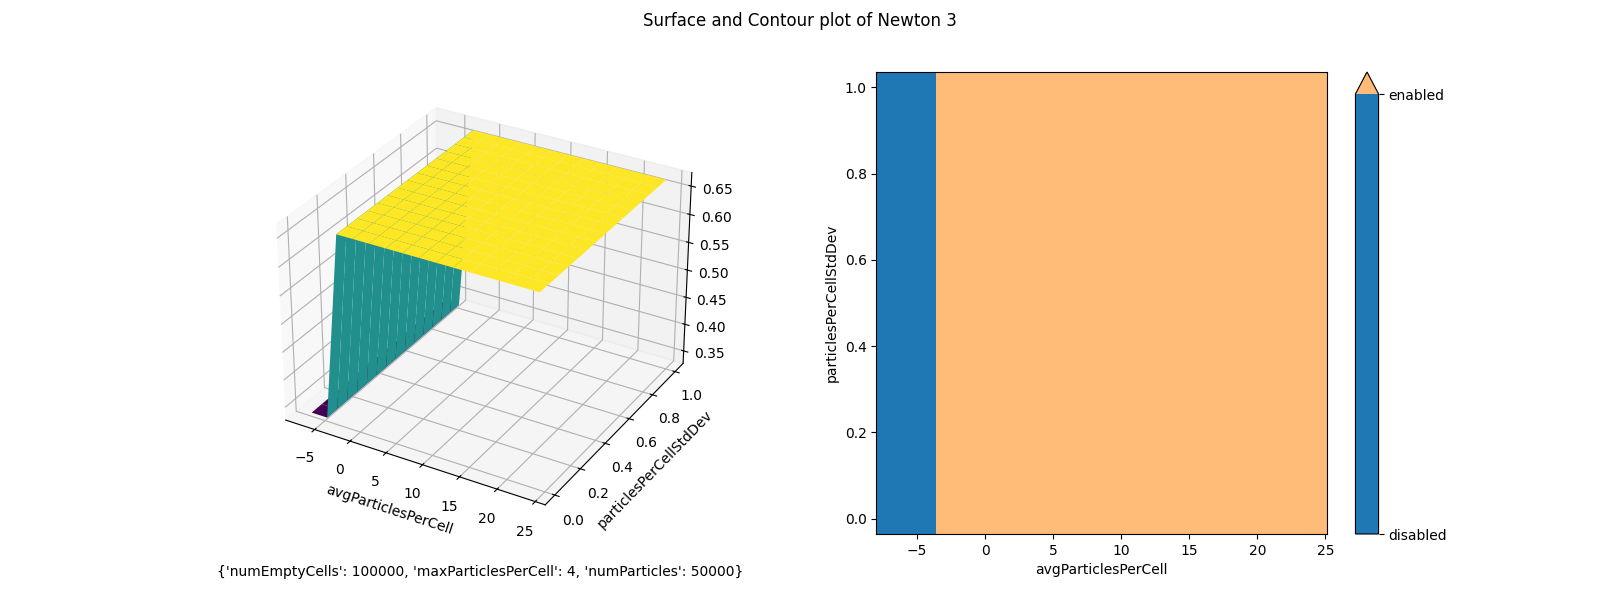

In [20]:
for fis in fiss.values():
    dim = fis.consequent_name
    label_map = {}
    for algo, value in algo_ranking[dim].items():
        label_map[value] = algo

    plot = plot3D_surface(fis.getInputCrispSets(), lambda data: algo_ranking[dim][fis.predictClosest(
        data, algo_ranking[dim])[1]], {
        "y": "particlesPerCellStdDev", "x": "avgParticlesPerCell", "z": dim}, labelMap=label_map, mesh=15, fixed_values={"numEmptyCells": 100000, "maxParticlesPerCell": 4, "numParticles": 50000})
    plot.show()

# Findings

- MoM works way better than the other methods.
- This is probably since the output variable is categorical and therefore interpolating between them is not a good idea.
  - Also the placement on the x-axis is somehow arbitrary. This also makes interpolation meaningless
- Traversal is very hard to predict. Maybe because there are so many possible values.